# PostSelecttML: Modeling Notebook Locally Run Modeling
### by Dolci Key 

 In following this notebook, I will run the current best model locally. 

## Import Libraries

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 


import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, metrics
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Accuracy, Recall
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight


from PIL import Image
import pydot
import graphviz

import pickle
from timeit import default_timer as timer

import os
import gc


## Importing Data 

Here we have the train, validation, and hold out set directories and then the paths to the reject(X) and select(y/target). 

In [22]:
# Train

train_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN'

# Split X and Y if needed 
train_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/reject'
train_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/select'

# Validation 
validation_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION'

# Split X and Y if needed 
test_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/reject'
test_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/select'

# Test/Hold Out Set 

test_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST'

# Split X and Y if needed 
hold_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/reject'
hold_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/select'

## Setting up the Training, Validation, and Test sets. 

for the training set, we will use the horizontal_flip to augment the minority class as well as adding zoom range up to 30%. We have included the target size of the images which are 500,333 pixels each, set the color mode to RGB (color), and the class mode is binary. 

In [24]:
#Training
train_set = image.ImageDataGenerator(rescale = 1/255, horizontal_flip = True, zoom_range = .3).flow_from_directory(train_dir,
                                                                  target_size = (500,333), 
                                                                  color_mode='rgb',
                                                                  class_mode = 'binary')



Found 1954 images belonging to 2 classes.


In [25]:
# Validation Set
validation_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(validation_dir,
                                                                shuffle= True,
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 698 images belonging to 2 classes.


In [47]:
# Test set / Hold out Set                                                               
test_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                shuffle = False, 
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 769 images belonging to 2 classes.


## Vanilla Model 

First, I will run a very simple model to get an idea of a baseline, or a starting point to really work from. The metrics I am most interested in is recall as I would much rather get a bad photo mixed in with the good ones occasionally, rather than a good one tossed out with the bad. 

In [31]:
# Vanilla model 

HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [103]:
vanilla_model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr=.0001),
                metrics = ['binary_accuracy', 'Recall', 'Precision'])

In [104]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

vanilla = model.fit(train_set, epochs = 5,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 334s 5s/step - loss: 0.3441 - binary_accuracy: 0.8920 - recall: 0.0104 - precision: 0.0909 - val_loss: 0.8603 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
62/62 [==============================] - 355s 6s/step - loss: 0.3286 - binary_accuracy: 0.9012 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.8538 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
62/62 [==============================] - 300s 5s/step - loss: 0.3330 - binary_accuracy: 0.9012 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.8114 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
62/62 [==============================] - 298s 5s/step - loss: 0.3287 - binary_accuracy: 0.9012 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.8265 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


## Model Summary, Evaluation, and Prediction on Unseen Data

In [107]:
vanilla_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 40, 64)       

In [108]:
vanilla_model.evaluate(test_set)

25/25 [==============================] - 26s 1s/step - loss: 0.4752 - binary_accuracy: 0.8375 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.4751628637313843, 0.8374512195587158, 0.0, 0.0]

In [ ]:
vanilla_model.save('SCRIPTS/model_script\assets')

## Vanilla Model with Class Weights 

So now that I have an idea, let's see if weighting the classes helps with the scores. 

### Weighting the classes 
For later usage, we will weight the classes to help with class imbalance. 

In [79]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_set.classes)
weights = dict(zip([0, 1], weights))
weights

{0: 0.5547984099943214, 1: 5.062176165803109}

In [80]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [109]:
model.compile(loss ='binary_crossentropy',  
                optimizer = optimizers.RMSprop(lr = 0.0001), 
                weighted_metrics = 'Recall',
                metrics = 'binary_accuracy')

In [110]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

weighted_vanilla = model.fit(train_set, epochs = 5, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 297s 5s/step - loss: 0.7444 - binary_accuracy: 0.6351 - recall: 0.3316 - val_loss: 0.6712 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 2/5
62/62 [==============================] - 298s 5s/step - loss: 0.7149 - binary_accuracy: 0.5440 - recall: 0.4352 - val_loss: 0.6961 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 3/5
62/62 [==============================] - 296s 5s/step - loss: 0.7052 - binary_accuracy: 0.5179 - recall: 0.4974 - val_loss: 0.6553 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 4/5
62/62 [==============================] - 295s 5s/step - loss: 0.7135 - binary_accuracy: 0.4816 - recall: 0.5078 - val_loss: 0.6577 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 5/5
62/62 [==============================] - 295s 5s/step - loss: 0.7168 - binary_accuracy: 0.5261 - recall: 0.3782 - val_loss: 0.6887 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Total Time Elapsed:  25 

## Model Summary, Evaluation, and Prediction on Unseen Data

In [111]:
weighted_vanilla.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 40, 64)       

In [106]:
weighted_vanilla.evaluate(test_set)

25/25 [==============================] - 26s 1s/step - loss: 0.4752 - binary_accuracy: 0.8375 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.4751628637313843, 0.8374512195587158, 0.0, 0.0]

In [ ]:
weighted_vanilla.save('SCRIPTS/weighted_vanilla\assets')

## Iterative Modeling

In [88]:
HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid"))

In [114]:
model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr= 0.0001),
                metrics = ['accuracy', 'binary_accuracy', 'Recall'])

In [115]:
# Start timer to keep track of how long model is running for
start = timer()

model_script = model.fit(train_set, epochs = 10, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
62/62 [==============================] - 332s 5s/step - loss: 0.7058 - accuracy: 0.5901 - binary_accuracy: 0.5901 - recall: 0.4560 - val_loss: 0.7252 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 2/10
62/62 [==============================] - 372s 6s/step - loss: 0.7055 - accuracy: 0.5302 - binary_accuracy: 0.5302 - recall: 0.4611 - val_loss: 0.7041 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 3/10
62/62 [==============================] - 472s 8s/step - loss: 0.7156 - accuracy: 0.4969 - binary_accuracy: 0.4969 - recall: 0.4611 - val_loss: 0.6674 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 4/10
62/62 [==============================] - 622s 10s/step - loss: 0.7128 - accuracy: 0.5507 - binary_accuracy: 0.5507 - recall: 0.3679 - val_loss: 0.7171 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 5/10
62/62 [==============================] - 618

## Model Summary, Evaluation, and Prediction on Unseen Data

In [116]:
model_script.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 40, 64)       

In [117]:
model_script.evaluate(test_set)

25/25 [==============================] - 31s 1s/step - loss: 0.6877 - accuracy: 0.6151 - binary_accuracy: 0.6151 - recall: 0.2160


[0.6877250075340271,
 0.6150845289230347,
 0.6150845289230347,
 0.2160000056028366]

In [ ]:
model_script.predict(test_set)

In [137]:
model_script.save('SCRIPTS/model_script\assets')

INFO:tensorflow:Assets written to: SCRIPTS/model_ivssets/assets


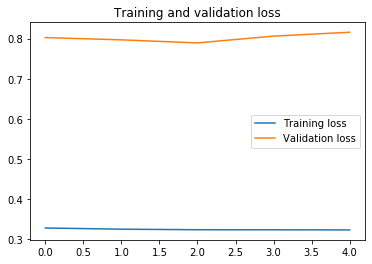

In [114]:
model_ = model_script.history
epochs = model_script.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

In [60]:
test_generator = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(
    directory=test_dir,
    target_size=(500, 333),
    color_mode="rgb",
    batch_size = 32,
    class_mode='binary',
    shuffle=False
)

test_generator.reset()

Found 769 images belonging to 2 classes.


In [65]:
pred = model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

25/25 [==============================] - 19s 759ms/step


In [66]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})